In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


In [2]:
def imshow(img):
    plt.axis("off")
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.show()
    

In [54]:
class DetectionError(Exception):
    pass

In [55]:
from enum import Enum

class Color(Enum):
    YELLOW = 1
    RED = 2
    GREEN = 3
    BLUE = 4


In [4]:
RED_BGR = (0,0,255)
YELLOW_BGR = (0,255,255)
GREEN_BGR = (0,255,0)
BLUE_BGR = (255,0,0)

In [5]:
cap = cv2.VideoCapture("./videos/gameplay_phone_clip.mp4")
if not cap.isOpened():
    raise Exception("Could not open")


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width, frame_height)

fps = cap.get(cv2.CAP_PROP_FPS)
fps

1920 1080


29.661252107835814

4207.320848584175
4204.977702736855


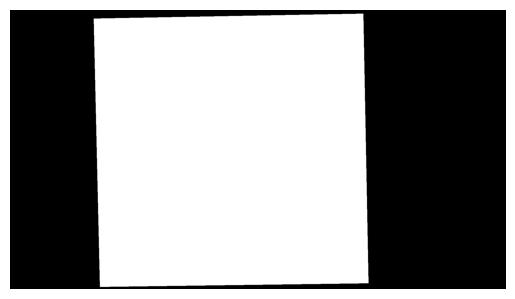

In [7]:
# calculating boardmask
def get_board_mask(frame):
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    edges = cv2.Canny(blurred,100,100)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = []
    for contour in contours:
        arc_length = cv2.arcLength(contour, True) 
        if arc_length < 1000:
            continue
            
        approx = cv2.approxPolyDP(contour, 0.02 * arc_length ,True)
        if len(approx) == 4:
            print(cv2.arcLength(contour, True))
            rectangles.append(approx)
            
    # assert len(rectangles) == 1
    rectangle = rectangles[0] #CHEAP HACK
    board_mask =  cv2.drawContours(np.zeros_like(edges), [rectangle], -1, (255,0,0), -1)
    return np.dstack([board_mask, board_mask, board_mask])

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
board_mask = get_board_mask(frame)
imshow(board_mask)


In [119]:
COLOR_RANGES = {
    Color.RED: [
        (np.array([0, 120, 70]), np.array([10, 255, 255])), 
        (np.array([170, 120, 70]), np.array([180, 255, 255]))
    ],
    Color.YELLOW: [
        (np.array([20, 100, 100]), np.array([30, 255, 255]))
    ],
    Color.GREEN: [
        (np.array([35, 50, 50]), np.array([85, 255, 255]))
    ],
    Color.BLUE: [
       (np.array([90, 50, 50]), np.array([130, 255, 255])) 
    ],
}

def detect_dominant_color(image_fragment) -> Color:
    hsv = cv2.cvtColor(image_fragment, cv2.COLOR_BGR2HSV)
    
   
    color_counts = {color: 0 for color in color_ranges.keys()}
    for color, ranges in COLOR_RANGES.items():
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_counts[color] += cv2.countNonZero(mask)
    
    dominant_color = max(color_counts, key=color_counts.get)
    
    return dominant_color


In [ ]:
COL

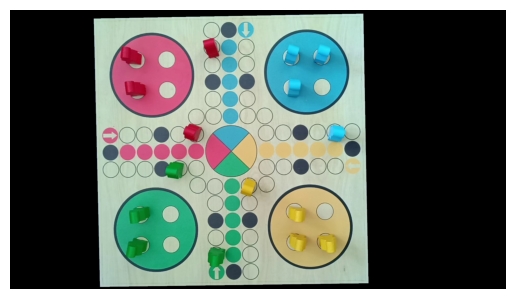

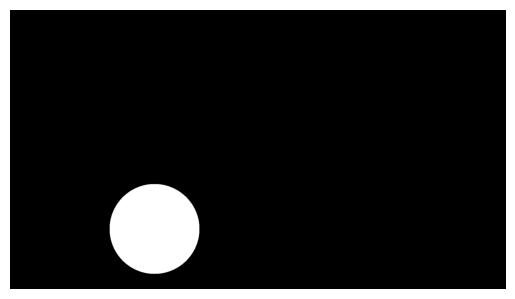

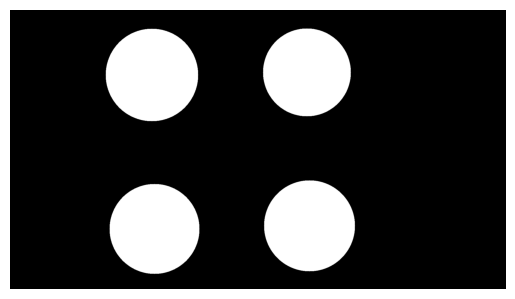

In [69]:

def get_home_masks(frame):
    assert len(frame.shape) == 3, "frame must be BGR"
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(
        frame_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 2,
        # TODO: HOME IS CIRCLE IN CIRCLE -> make minDist small, find center pairs which are very close
        # and delete the smaller
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 100,
        param2=100,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.5),
    )

    homes = {
                 Color.RED: dict(center = None, radius = None, mask=None),      
                 Color.BLUE: dict(center = None, radius = None, mask=None),
                 Color.GREEN:  dict(center = None, radius = None, mask=None),
                 Color.YELLOW: dict(center = None, radius = None, mask=None),
        }
                 
        
    circles = np.uint16(np.around(circles))
    assert circles.shape[1] == 4, f"Found not 4 homes, but {circles.shape[1]}"
    for (i, color) in zip(circles[0,:], homes):
        mask =   np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
        cv2.circle(mask ,(i[0],i[1]),int(1.1*i[2]),(255,255,255),-1)
        color = detect_dominant_color(frame & mask)
        homes[color]["center"] = (i[0],i[1])
        homes[color]["radius"] = i[2]
        homes[color]["mask"] = mask
       

    return homes

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
frame = np.where(board_mask, frame, 0)
homes = get_home_masks(frame)
imshow(frame)
imshow(homes[Color.GREEN]["mask"])
all_homes_mask = homes[Color.GREEN]["mask"] | homes [Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]
imshow(all_homes_mask)

In [190]:
# cap.set(cv2.CAP_PROP_POS_FRAMES,0)
# ret, frame = cap.read()
# frame = frame & board_mask & ~all_homes_mask
# frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# lower_red1 = np.array([0, 120, 70])
# upper_red1 = np.array([10, 255, 255])
# lower_red2 = np.array([170, 120, 70])
# upper_red2 = np.array([180, 255, 255])
# mask1 = cv2.inRange(frame_hsv, lower_red1, upper_red1)
# mask2 = cv2.inRange(frame_hsv, lower_red2, upper_red2)
# red_mask = cv2.bitwise_or(mask1, mask2)
# red_mask = np.dstack([red_mask, red_mask, red_mask])
# imshow(red_mask)
# # frame = cv2.cvtColor(f
# imshow(frame)

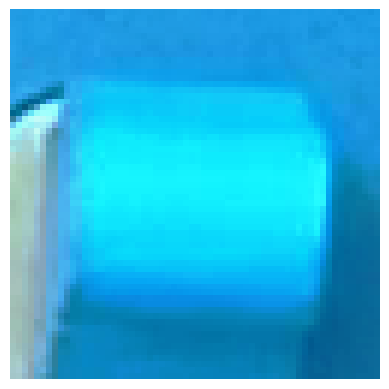

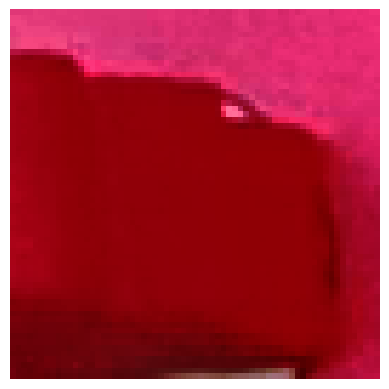

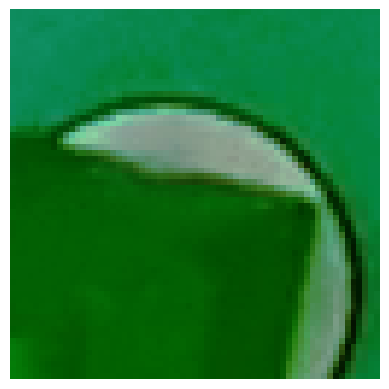

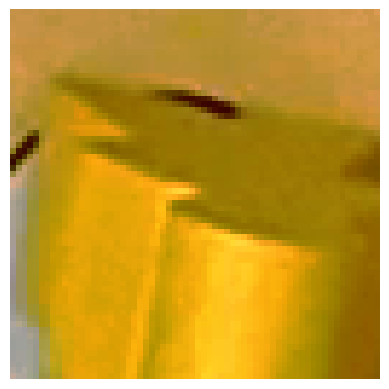

In [145]:


def get_pawn_image(frame, home: dict):
    my_home_center = home["center"]
    my_home_radius = home["radius"]
    
    x, y = my_home_center
    w, h = int(0.4*my_home_radius), int(0.4*my_home_radius) 
    x -= int(0.1 * my_home_radius)
    y += int(0.1 * my_home_radius)
    
    # pawn = frame(x,y) , (x - w,y + h)
    pawn = frame[y: y+h, x-w : x]
    return pawn

cap.set(cv2.CAP_PROP_POS_FRAMES,53)
ret, frame = cap.read()
frame_eq = np.zeros_like(frame)
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])

blue_pawn = get_pawn_image(frame_eq, homes["blue"])
red_pawn = get_pawn_image(frame_eq, homes["red"])
green_pawn = get_pawn_image(frame_eq, homes["green"])
yellow_pawn = get_pawn_image(frame_eq, homes["yellow"])
imshow(blue_pawn)
imshow(red_pawn)
imshow(green_pawn)
imshow(yellow_pawn)

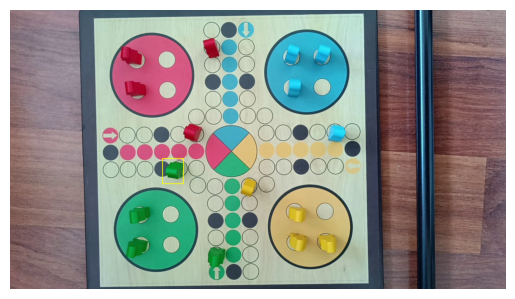

In [177]:
def get_pawn_boxes(sidewalk, target):
    sidewalk_hsv = cv2.cvtColor(sidewalk, cv2.COLOR_BGR2HSV)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2HSV)
    target_hs_histogram = cv2.calcHist([target],[0,1], None, [180,256], [0,180,0,256])
    cv2.normalize(target_hs_histogram, target_hs_histogram,0,255,cv2.NORM_MINMAX)
    B = cv2.calcBackProject([sidewalk_hsv], [0,1], target_hs_histogram, [0,180,0,256],1)
    # B = cv2.morphologyEx(B, cv2.MORPH_ERODE, np.ones((3,3)))
    # imshow(B)
    B = cv2.morphologyEx(B, cv2.MORPH_ERODE, np.ones((3,3)))
    
    B = cv2.morphologyEx(B, cv2.MORPH_DILATE, np.ones((29,29)), iterations=2)
    B = cv2.morphologyEx(B, cv2.MORPH_ERODE, np.ones((15,15)))
    # imshow(B)
    
    B = B > 10
    # imshow(B)
    contours, _ = cv2.findContours(B.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pawn_boxes = []
    min_pawn_area = (min(frame_width, frame_height) * 0.02)**2
    max_pawn_area = (min(frame_width, frame_height) * 0.10)**2
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_pawn_area < area < max_pawn_area:
            pawn_boxes.append(cv2.boundingRect(contour))
            
    if len(pawn_boxes) > 4:
        #raise DetectionError(f"Detected {len(pawn_boxes)} pawns")
        ...
        
    return pawn_boxes


cap.set(cv2.CAP_PROP_POS_FRAMES,20)
ret, frame = cap.read()

frame_eq = np.zeros_like(frame)
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])
# imshow(frame_eq)
board = frame_eq & board_mask
sidewalk = board & ~all_homes_mask

target = green_pawn
pawn_boxes = get_pawn_boxes(sidewalk, target)
for (x,y,w,h) in pawn_boxes:
    cv2.rectangle(frame, (x, y), (x+w, y+h), YELLOW_BGR, 2)
imshow(frame)

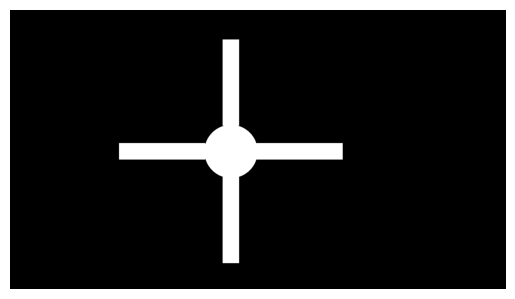

In [114]:



def get_target_bases(frame):
    circles = cv2.HoughCircles(
            frame_gray,
            method = cv2.HOUGH_GRADIENT,
            dp = 2,
            minDist = int(min(frame_height, frame_width)),
            param1 = 100,
            param2=100,
            minRadius=int(min(frame_height, frame_width) * 0.05),
            maxRadius=int(min(frame_height, frame_width) * 0.1),
        )
    circles = np.uint16(np.around(circles))
    assert len(circles) == 1
    (x,y,r) = circles[0][0]
    targets = dict()
    

    center_circle_mask = np.zeros_like(frame)  
    cv2.circle(center_circle_mask ,(x,y),int(r*1.05),(255,255,255),-1)
    targets["center"] = center_circle_mask
    
    target_base_thickness = int(min(frame_height, frame_width) * 0.06)
    target_base_length = int(min(frame_height, frame_width) * 0.31)
    
    left_target_x = x-r-target_base_length
    left_target_y = y-target_base_thickness//2
    
    up_target_x = x - target_base_thickness//2
    up_target_y = y - r - target_base_length
    
    down_target_x = x - target_base_thickness//2
    down_target_y = y + r
    
    right_target_x = x + r
    right_target_y = y - target_base_thickness//2
    
    
    empty_mask = np.zeros_like(frame)  
    left_target_mask = cv2.rectangle(empty_mask, (left_target_x, left_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & left_target_mask)
    targets[color] = left_target_mask
    
    empty_mask = np.zeros_like(frame)
    up_target_mask = cv2.rectangle(empty_mask, (up_target_x, up_target_y, target_base_thickness, target_base_length ), (255,255,255), -1)
    color = detect_dominant_color(frame & up_target_mask)
    targets[color] = up_target_mask
    
    empty_mask = np.zeros_like(frame)
    down_target_mask = cv2.rectangle(empty_mask, (down_target_x, down_target_y, target_base_thickness, target_base_length), (255,255,255), -1)
    color = detect_dominant_color(frame & down_target_mask)
    targets[color] = down_target_mask
    
    empty_mask = np.zeros_like(frame)   
    right_target_mask = cv2.rectangle(empty_mask, (right_target_x, right_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & right_target_mask)
    targets[color] = right_target_mask
    
    return targets

cap.set(cv2.CAP_PROP_POS_FRAMES,20)
ret, frame = cap.read()
targets = get_target_bases(frame)
all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]
imshow(all_target_bases_mask)


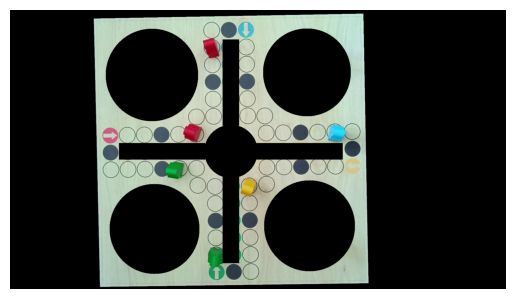

In [116]:
board = frame & board_mask
sidewalk = board & ~all_homes_mask & ~all_target_bases_mask
imshow(sidewalk)

# Result 

In [118]:
%%time
cap = cv2.VideoCapture(videopath)
if not cap.isOpened():
    raise Exception("Could not open")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))


fps = cap.get(cv2.CAP_PROP_FPS)

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
video_out = cv2.VideoWriter(
    "output.avi",
    cv2.VideoWriter_fourcc(*"DIVX"),
    fps,
    (frame_width, frame_height),
)

while cap.isOpened():
    ret, frame = cap.read()
    if frame is None:
        print(ret)
        break
    frame_eq = np.zeros_like(frame)
    frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
    frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
    frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])
    # cv2.imshow("image", frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    board = np.where(board_mask, frame_eq, 0)
    sidewalk = board & ~all_homes_mask & ~all_target_bases_mask
    # We have to automaticaly detect it - from home?
    
    
    try:
        # target = cv2.imread("./fotos/yellow_pawn.png")
        target = yellow_pawn
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), YELLOW_BGR, 2)
    except DetectionError as e:
        print(e)
    
    try:
        # target = cv2.imread("./fotos/red_pawn.png")
        target = red_pawn
        
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), RED_BGR, 2)
    except DetectionError as e:
        print(e)
    try:
        # target = cv2.imread("./fotos/green_pawn.png")
        target = green_pawn
        
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), GREEN_BGR, 3)
    except DetectionError as e:
        print(e)
    
    try:
        # target = cv2.imread("./fotos/blue_pawn.png")
        target = blue_pawn
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), BLUE_BGR, 2)
    except DetectionError as e:
        print(e)
        
    video_out.write(frame)
#     cv2.imshow('video', frame)
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
        
# cv2.destroyAllWindows() 
clear_output()

NameError: name 'videopath' is not defined

In [196]:
!mpv output.avi

=● Video  --vid=1  (mpeg4 1920x1080 29.661 fps)
VO: [gpu] 1920x1080 yuv420p
(Paused) V: 00:00:02 / 00:00:03 (63%)
Exiting... (Quit)
>